# Profile likelihood for $\Lambda$CDM

In [1]:
from getdist import mcsamples, plots, chains
from getdist.mcsamples import MCSamplesError
import numpy as np
from subprocess import run
import os
from yaml import dump
from cobaya.yaml import yaml_load_file
from copy import deepcopy
from lkl_prof_functions import *

### Read in chains 

- Set chains_dir as the folder where chain .txt files are found 
- Set chain_file as the filename up until the .1.txt etc
- Any chain settings you want, although these are irrelevant 
- Set minimizer settings here. Eg. if you're looking for a global minimum (besides testing, global minimum should be on). 
- Minimizer settings also inherits from the .yaml file for global minimum!! Ensure global minimum is also sought there 

In [2]:
# chains_dir = "/Users/tanvikarwal/Desktop/Early_dark_energy/likelihood_profile/chains/lcdm_base/"
chain_file = 'lcdm_cmb_bao_sne_'
chains_dir = '/home2/karwal/mcmc_chains/ede_lkl_profile/lcdm_base/'
os.chdir(chains_dir)

settings = {'ignore_rows' : 0.2}
mcmc_chains = mcsamples.loadMCSamples(chains_dir+chain_file, settings=settings)

minimizer_settings = {'minimize': 
                                {   'method': 'bobyqa',
                                    'covmat' : 'auto',
                                    # 'override_bobyqa' : {'seek_global_minimum': 'true'}
                                }
                      }

### Pick param to vary and increment

Ideally, only the parameter should be provided. 
- TBC: get increment from the MCMC sigma 
- TBC: get min and max from when $\chi^2$ has substantially dropped? 

For now, assuming these are input. 

(TBC = to be coded)

In [3]:
prof_param = 'H0'
prof_incr = 0.1
prof_min = 65.
prof_max = 74.

### Check if minimizer was run on all chains previously 
And if not, use above defined minimizer settings to run it. 

Ideally, TBC, get number of chains from mcmc and run that many minimizer processes. 

In [4]:
if not check_global_min(mcmc_chains=mcmc_chains, chains_dir=chains_dir, chain_file=chain_file):
    mcmc_yaml = yaml_load_file(chains_dir+chain_file+'.input.yaml')
    mcmc_yaml['sampler'] = minimizer_settings
    with open(chains_dir + chain_file + '.minimize.input.yaml', 'w') as yaml_file:
        dump(min_yaml, yaml_file, default_flow_style=False)

    run_minimizer(chain_file=chain_file, yaml_ext='', debug=False, processes=6)    

check_global_min: Found previously run MCMC chains and global minimizer. 


### Add minimized point to lkl profile text file 

So: 
1) load the global minimum file. 
2) check if we have a file with prof lkl values. 
    * If yes, check that it has the same parameters and in the right order. Proceed. 
    * If no file, start it and write the first line as param names. Proceed. 
    * If file yes, but parameters don't match, then print an error. Stop. 
2) check if global minimum params have already been written (first line of file)
    * If parameters are written, check that they match global minimum. Don't write them again
    * If parameters are written but don't match, spit out error. 
    * If no params written, add this current ML values for all parameters in append mode

In [5]:
param_names, param_ML, MLs = read_minimum(chains_dir, chain_file, extension='')

In [6]:
global_ML = deepcopy(MLs)
param_order = param_names

In [7]:
try: 
    if not match_param_names(param_names, chains_dir=chains_dir, chain_file=chain_file):
        raise FileExistsError
except FileNotFoundError:
    print("File not found. Starting a new file now: " + chains_dir + chain_file + '_lkl_profile.txt \n')
    with open(chains_dir + chain_file + '_lkl_profile.txt', 'w') as lkl_txt:
        lkl_txt.write("#")
        for param_recorded in param_names:
            lkl_txt.write("\t %s" % param_recorded)
        lkl_txt.write("\n")

match_param_names: Found existing file with correct name and parameters / parameter sequence. Will append to it. 
/Users/tanvikarwal/Desktop/Early_dark_energy/likelihood_profile/chains/lcdm_base/lcdm_cmb_bao_sne__lkl_profile.txt


In [8]:
lkl_prof_table = np.loadtxt(chains_dir + chain_file + '_lkl_profile.txt')
if lkl_prof_table.shape!=(0,):
    if not match_param_line(param_names, global_ML, chains_dir=chains_dir, chain_file=chain_file, loc=0):
        print("Something went wrong. The first line of the lkl_profile.txt file which should be global ML does not match the global ML in file \n"
             +chains_dir + chain_file + '.minimum')
        raise FileExistsError
else: 
    write_MLs(param_names, MLs, chains_dir=chains_dir, chain_file=chain_file)

## Likelihood profile 

### Set up lkl profile minimum input yaml file 
Only this should be read and manipulated by the rest of the code

Here I check that a "_lkl_prof" file has been created for the minimizer input yaml.

In [9]:
try:
    lkl_pro_yaml = yaml_load_file(chains_dir+chain_file+'_lkl_prof.minimize.input.yaml')
except FileNotFoundError:
    run("cp "+chains_dir+chain_file+'.minimize.updated.yaml'+" "+chains_dir+chain_file+'_lkl_prof.minimize.input.yaml', shell=True)
    lkl_pro_yaml = yaml_load_file(chains_dir+chain_file+'_lkl_prof.minimize.input.yaml')

We already have param_names and MLs saved. Update the param_ML with the values from the last entry in _lkl_prof.txt in case we're restarting / continuing a run. 

In [10]:
param_ML = read_lkl_output(chains_dir=chains_dir, chain_file=chain_file, loc=-1)
MLs = dict(zip(param_names, param_ML))

## Run loop over increments of profile lkl param 

While we are within the bounds of the profile param we want to explore: 

1) check if the point we are currently at i.e. param_ML and MLs, matches the last entry in the lkl_prof table.
    - if it does, the last minimum was run and saved successfully. 
    - if not, check if a minimum file exists. 
        - if it does, read it in and save it in the lkl prof txt. minimum run successfully. 
        - if not, this happens when we have updated the yaml but the minimizer didn't finish. Run the yaml again without updating. 
2) check if minimum was run and saved. 
    - if yes, update the yaml and increment the prof lkl param, update all other params to new values from current ML. Assign the MLs values for the independent params in the yaml as new reference starting points. 
3) run the minimizer 
4) save minimizer output 

In [ ]:
while MLs[prof_param] < prof_max:
    last_entry_matches_current_params = match_param_line(param_names, MLs, chains_dir=chains_dir, chain_file=chain_file, loc=-1)
    if last_entry_matches_current_params:
        run('rm '+chains_dir + chain_file + '_lkl_prof.minimum*', shell=True)
        minimum_successfully_run_and_saved = True
    else:
        try:
            param_names, param_ML, MLs = read_minimum(chains_dir, chain_file)
            write_MLs(param_order, MLs, chains_dir=chains_dir, chain_file=chain_file)
            run('rm '+chains_dir + chain_file + '_lkl_prof.minimum*', shell=True)
            minimum_successfully_run_and_saved = True 
            print("-----> Minimizer run successfully for "+prof_param+" = "+str(MLs[prof_param]))
        except OSError:
            minimum_successfully_run_and_saved = False
            print("-----> Minimizer not run for "+prof_param+" = "+str(MLs[prof_param]))
            print("       Rerunning this point")

    if minimum_successfully_run_and_saved:
        increment_update_yaml(MLs, lkl_pro_yaml, prof_param, prof_incr)
        run('rm '+chains_dir + chain_file + '_lkl_prof.minimize.updated.yaml', shell=True)

    run_minimizer(chain_file=chain_file, yaml_ext='_lkl_prof', debug=False, processes=6)

    param_names, param_ML, MLs = read_minimum(chains_dir, chain_file)
    break 

In [ ]:
param_names, param_ML, MLs = read_minimum(chains_dir, chain_file)
write_MLs(param_order, MLs, chains_dir=chains_dir, chain_file=chain_file)

(63, 82)

In [ ]:
exit

# Scrap code below

### Plot lkl profile
- Load proflkl param. Skip the first two rows because of proflkl output file error (bug now fixed)

In [12]:
prof_param_values = np.loadtxt(chains_dir+chain_file+'_lkl_profile.txt', skiprows=2, usecols=(np.where(param_names == prof_param)[0][0],))

- Load the $\chi^2$'s. Here, I'm doing each experiment separately because of a bug that messed up the proflkl output file. (bug now fixed) Note that this method might be more correct if you want to compare on $\chi^2$. The likelihood output by Cobaya includes normalisations and priors or something, such that $\left( -\log\mathcal{L} \right) \neq \frac{1}{2}\chi^2$
- Sum the $\chi^2$'s.

In [15]:
params_wanted = ['chi2__CMB', 'chi2__SN', 'chi2__BAO']
chis = np.loadtxt(chains_dir+chain_file+'_lkl_profile.txt', skiprows=2, usecols=(np.where(param_names == i)[0][0] for i in params_wanted))
chis = np.array([ chis[i,0]+chis[i,1]+chis[i,2] for i in range(chis.shape[0]) ])

- Plot. That one should be obvs. 

Text(0.5, 0, '$H_0$')

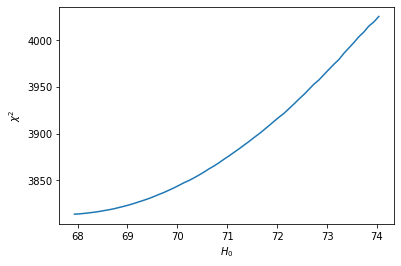

In [16]:
import matplotlib.pyplot as plt

plt.plot( prof_param_values, chis )
plt.ylabel(r'$\chi^2$')
plt.xlabel(r'$'+lkl_pro_yaml['params'][prof_param]['latex']+'$')

### Visualise how each parameter shifts with prof lkl param 

- Load all columns of output proflkl file
- plot all parameters in the file against the profile lkl parameter (this is the same as plotting against [1,2,3...]

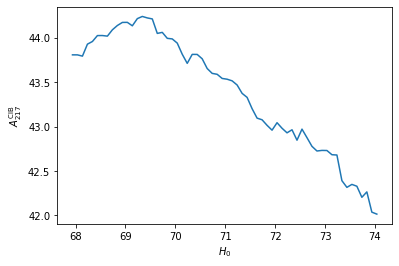

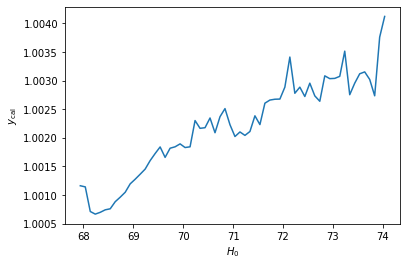

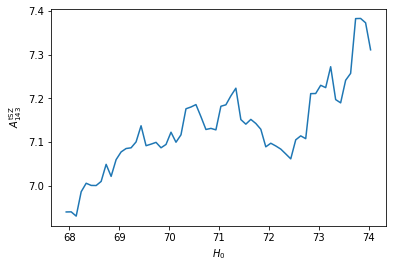

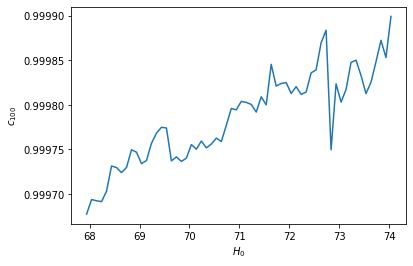

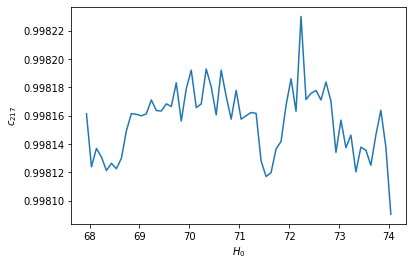

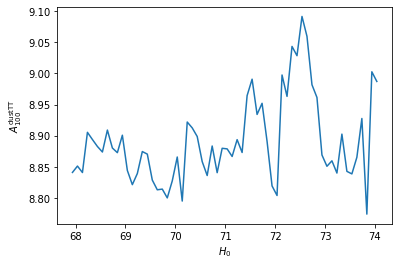

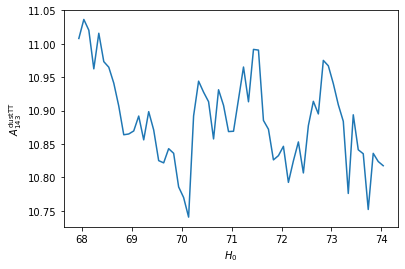

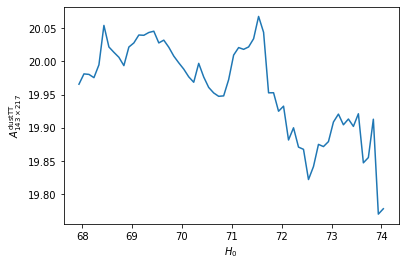

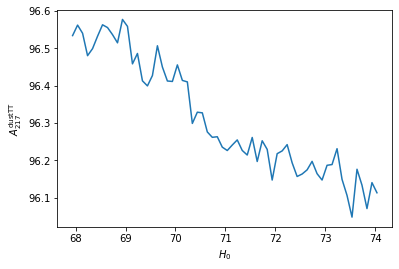

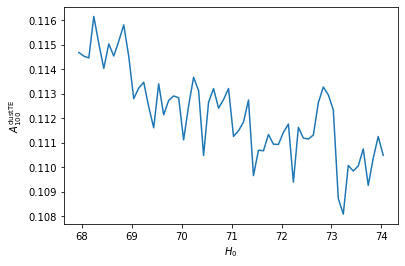

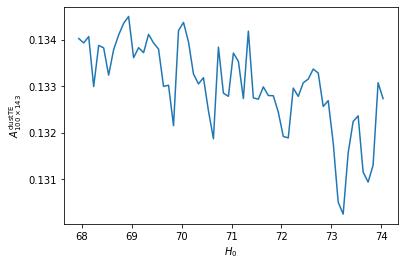

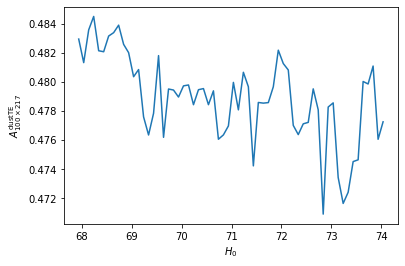

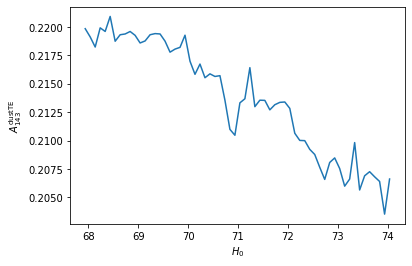

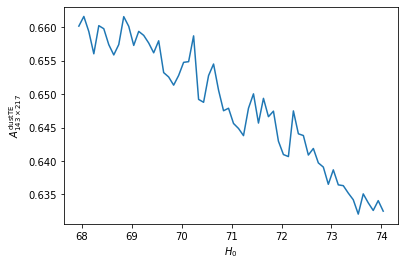

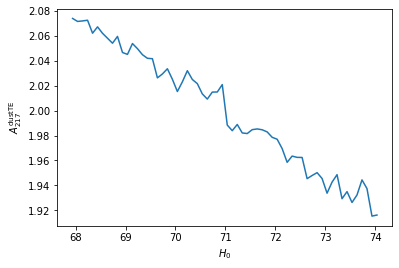

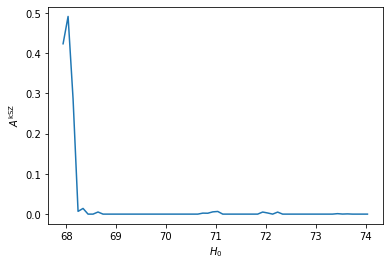

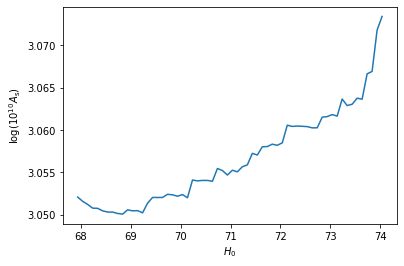

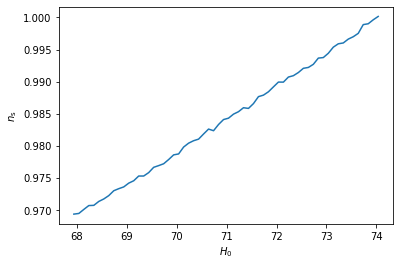

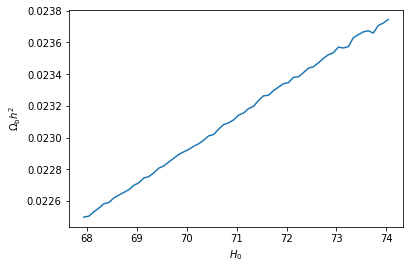

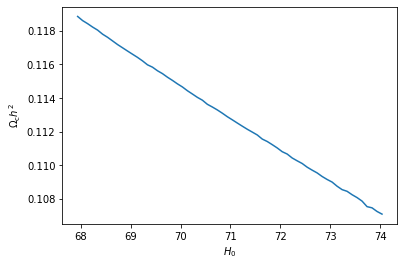

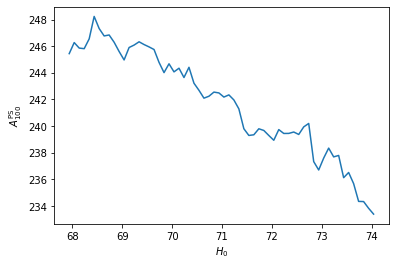

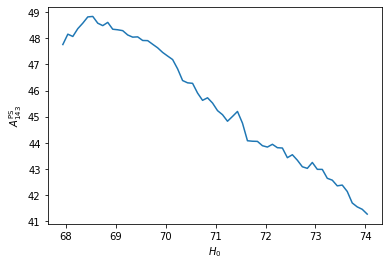

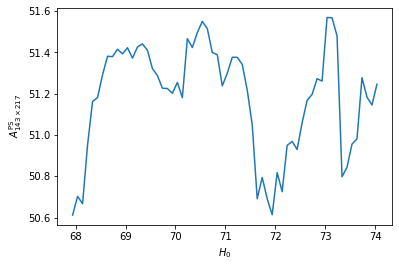

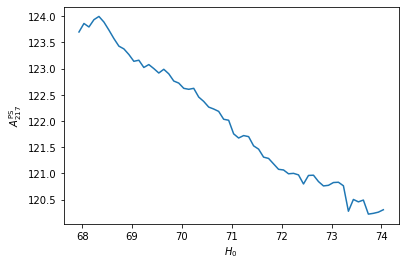

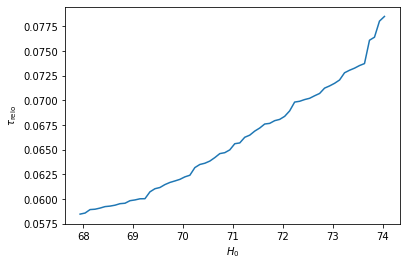

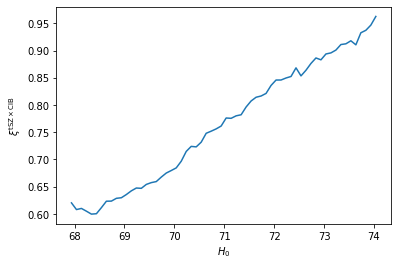

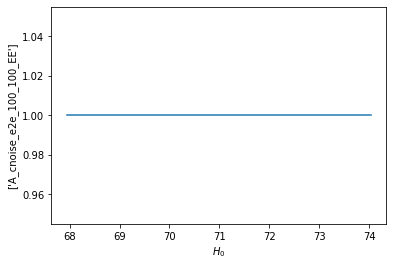

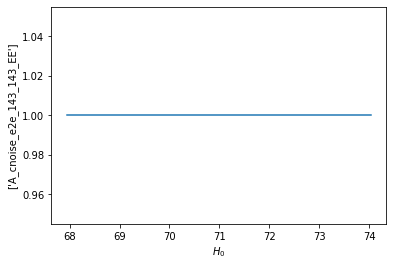

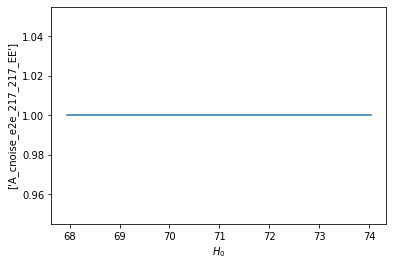

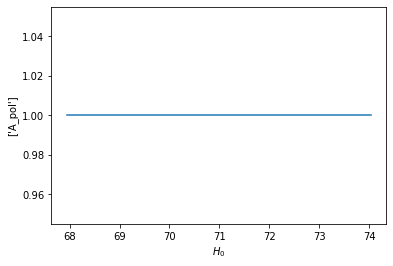

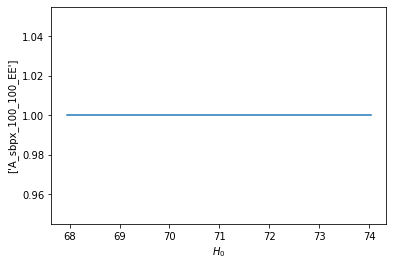

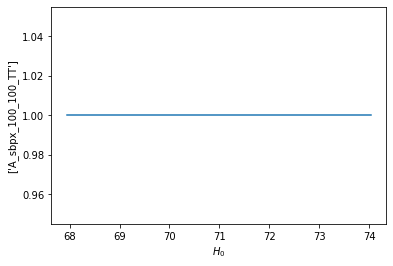

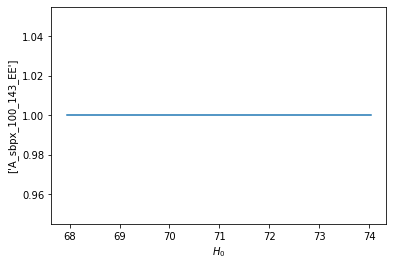

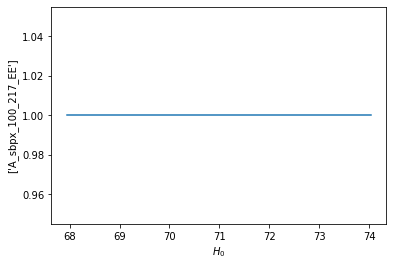

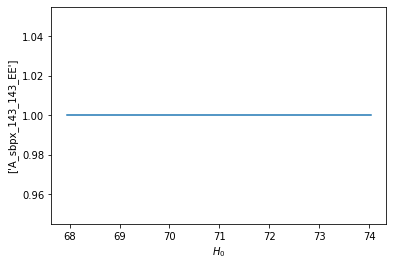

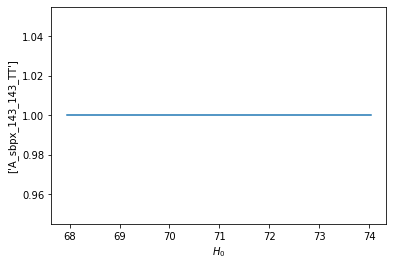

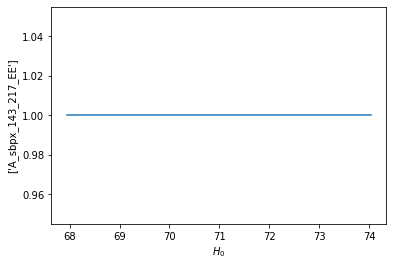

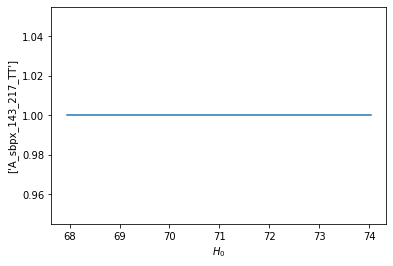

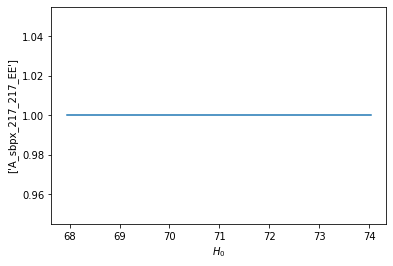

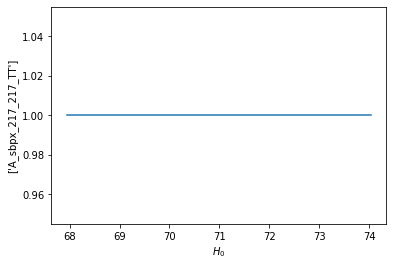

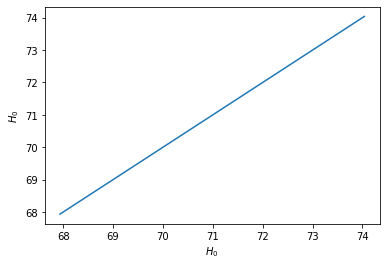

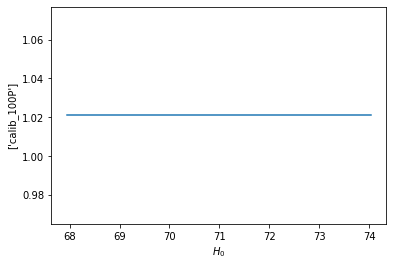

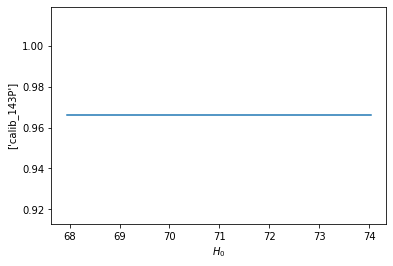

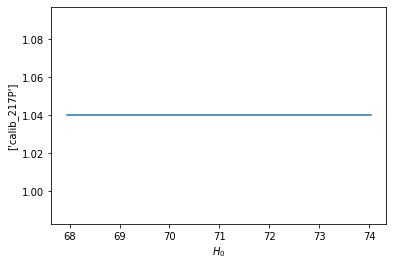

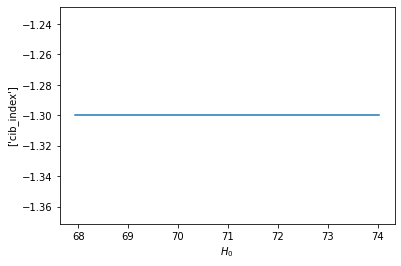

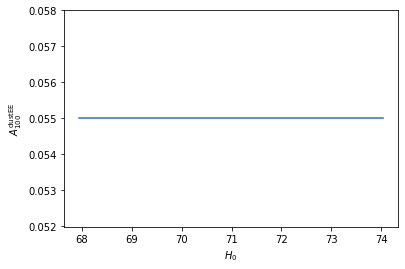

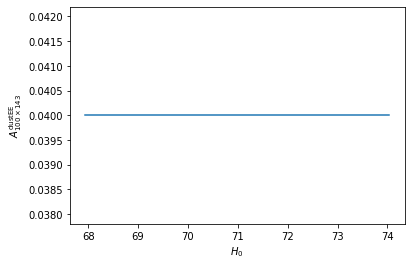

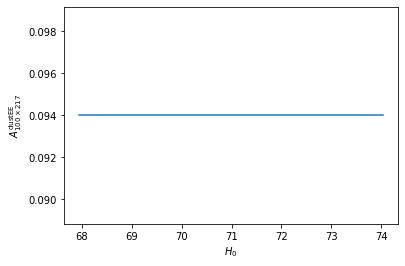

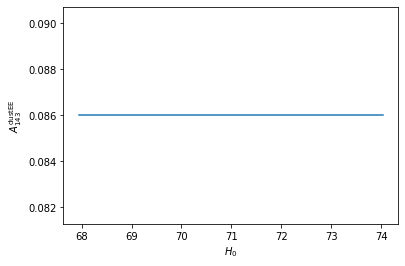

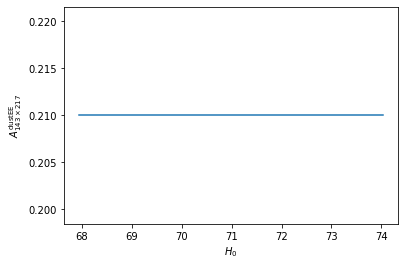

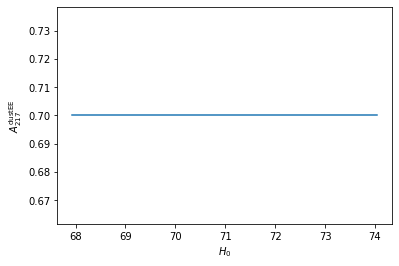

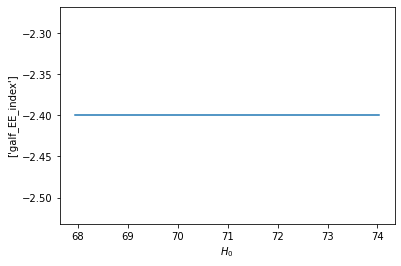

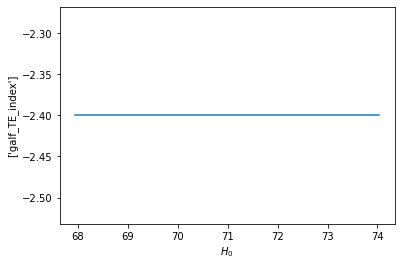

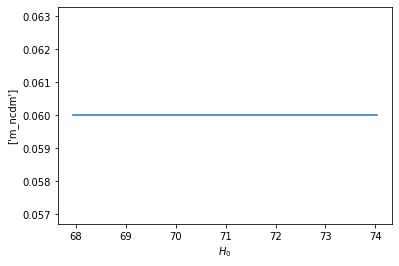

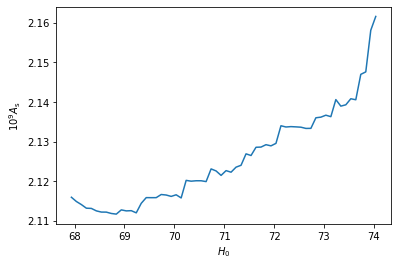

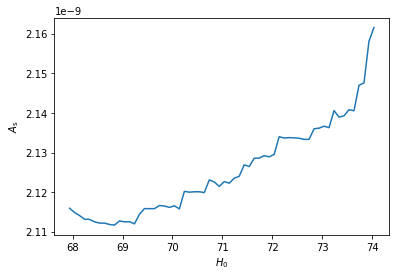

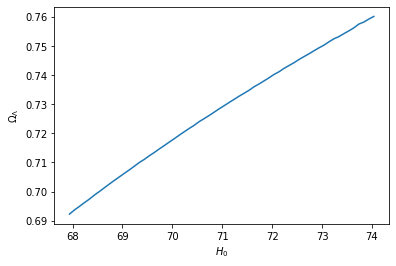

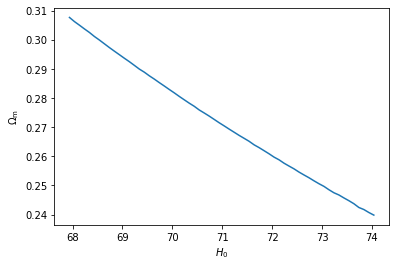

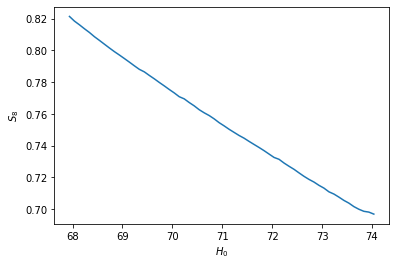

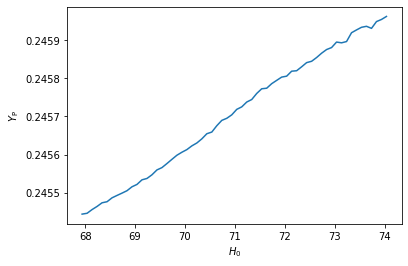

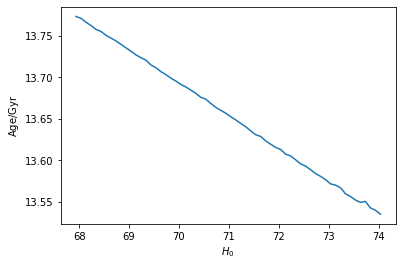

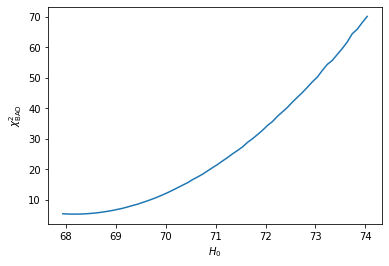

In [17]:
import matplotlib.pyplot as plt

all_MLs = np.loadtxt(chains_dir+chain_file+'_lkl_profile.txt', skiprows=2)
for i in range(all_MLs.shape[0]):
    plt.plot( all_MLs[:, np.where(param_names == prof_param)[0][0] ], all_MLs[:,i] )
    try:
        plt.ylabel(r'$'+lkl_pro_yaml['params'][param_names[i]]['latex']+'$')
    except KeyError:
        plt.ylabel([param_names[i]])
    plt.xlabel(r'$'+lkl_pro_yaml['params'][prof_param]['latex']+'$')
    plt.show()